In [4]:
import numpy as np
import cv2
import os
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from Thymio import Thymio

import vision
import globalNavigation

In [17]:
#RUN THIS CELL IF YOU MODIFIED MODULES AND DONT WANT TO RESTART KERNEL
import importlib
importlib.reload(vision)
importlib.reload(navigation)

<module 'navigation' from '/Users/ken/Dropbox/EPFL/Basics_of_Mobile_Robotics/Project/EPFL_MoRo_Project/src/navigation.py'>

# Detect Thymio position

The Thymio is detected by detecting the green circle (center of mass) and the blue point to detect the orientation. 

#### Read image and display it

<Figure size 432x288 with 0 Axes>

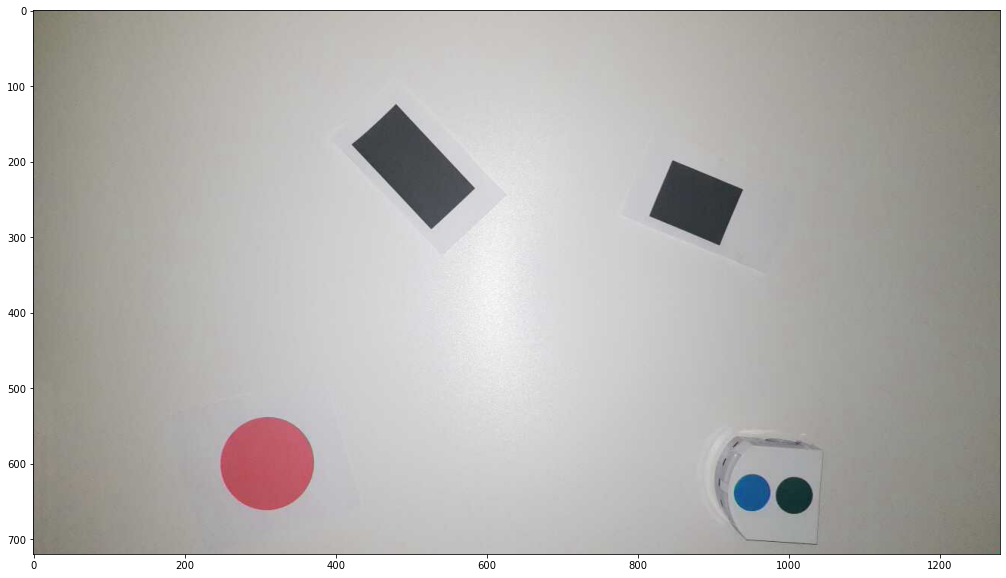

In [2]:
%matplotlib inline
cap = vision.VideoCapture("http://192.168.13.124:8080/video")
plt.figure()

viewCam = False

while viewCam:
    frame = cap.read()
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    plt.imshow(frame)
    plt.show()
    time.sleep(1)
    clear_output()
    
raw_frame = cap.read()
plt.figure(figsize = (50,10))
plt.imshow(cv2.cvtColor(raw_frame,cv2.COLOR_BGR2RGB))
plt.show()

[[[307.80002  601.80005   59.760002]]]


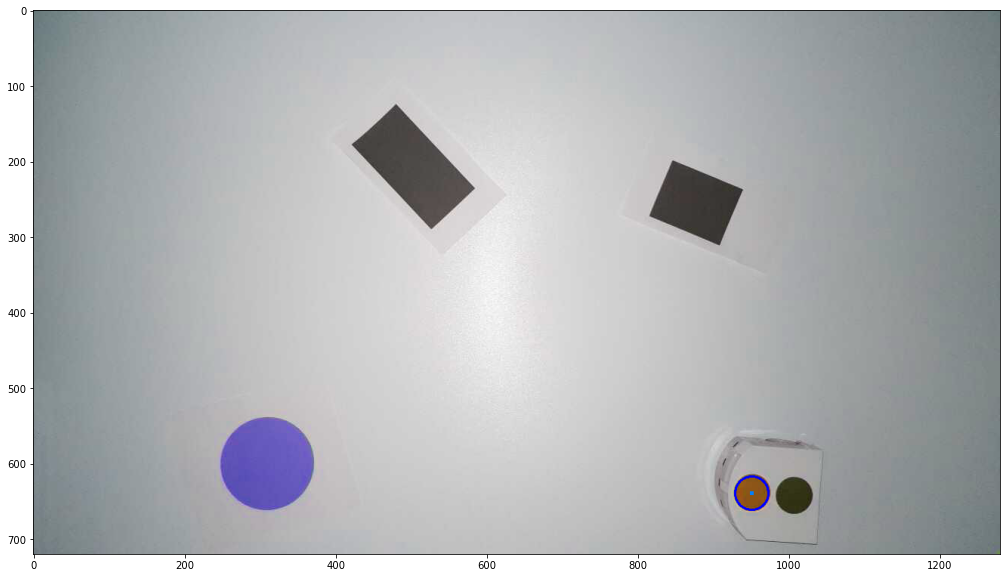

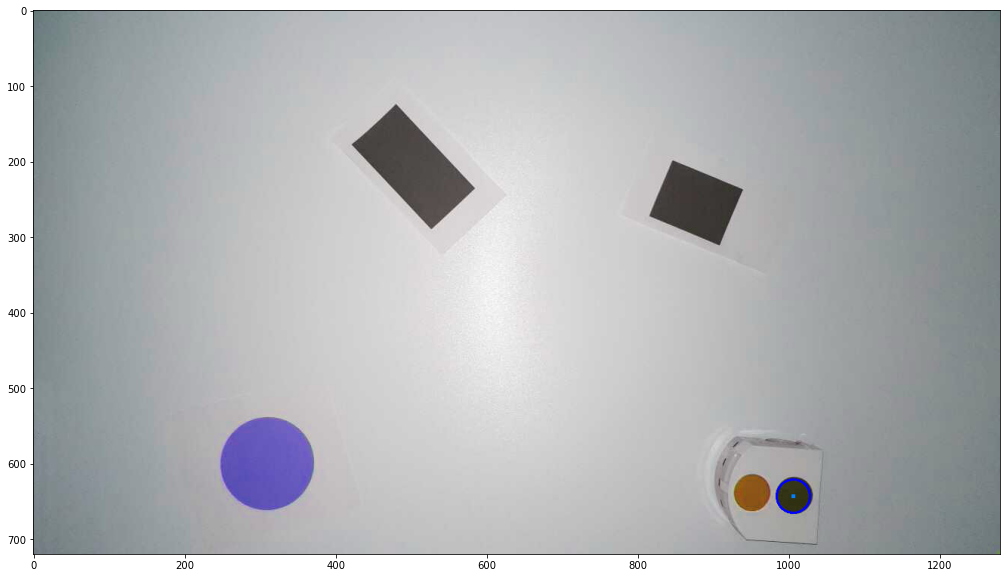

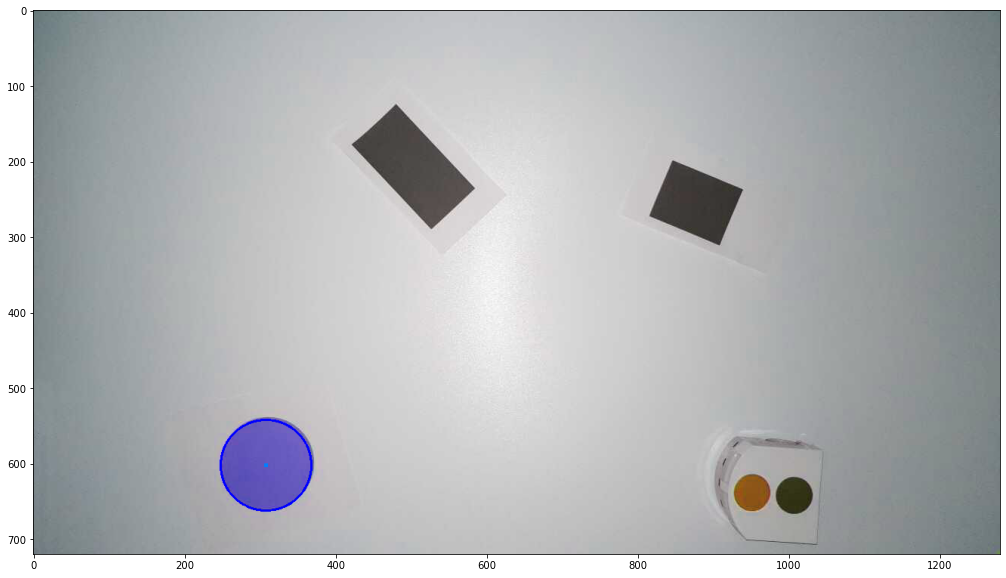

In [3]:
%matplotlib inline
frame = raw_frame.copy()
robot_front_absolute, front_image = vision.find_thymio_front(frame)
robot_center_absolute, center_image = vision.find_thymio_center(frame)
destination_center_absolute, destination_image = vision.find_destination_center(frame)
plt.figure(figsize = (50,10))
plt.imshow(front_image)
plt.show()
plt.figure(figsize = (50,10))
plt.imshow(center_image)
plt.show()
plt.figure(figsize = (50,10))
plt.imshow(destination_image)
plt.show()

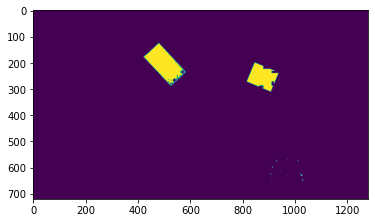

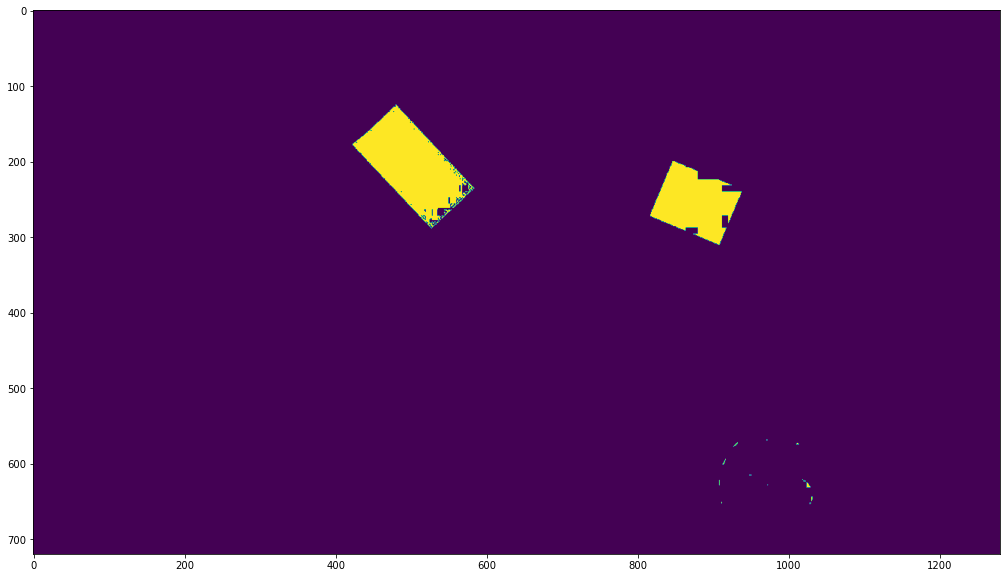

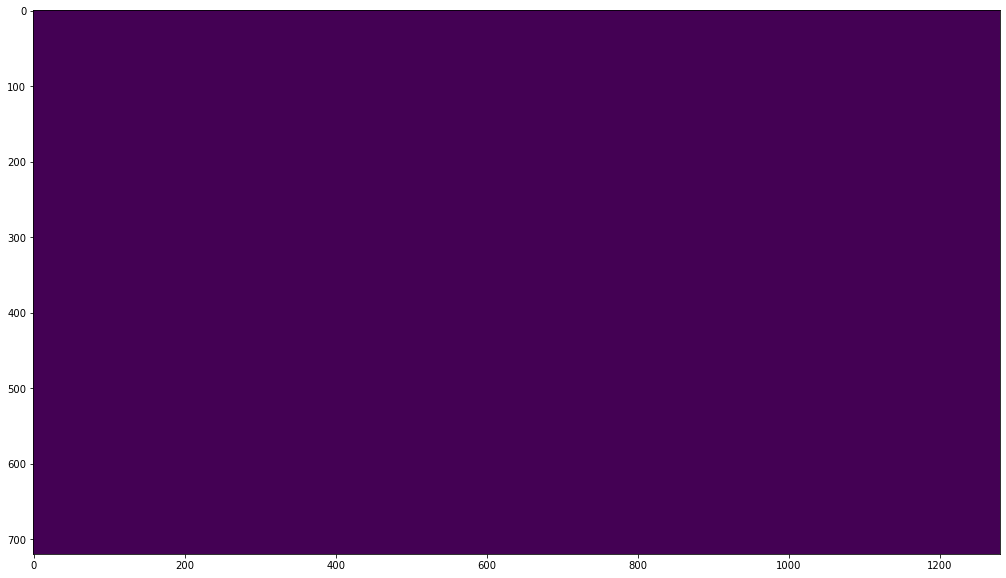

In [8]:
%matplotlib inline
importlib.reload(vision)
output_objects = vision.find_objects(frame)
output_objects = cv2.cvtColor(output_objects, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (50,10))
plt.imshow(output_objects)
plt.show()

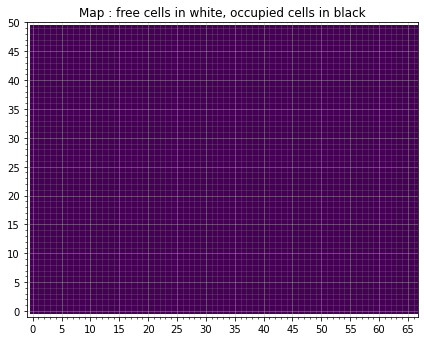

In [14]:
occupancy_grid, cmap = navigation.display_occupancy_grid(output_objects)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  4,  5]])

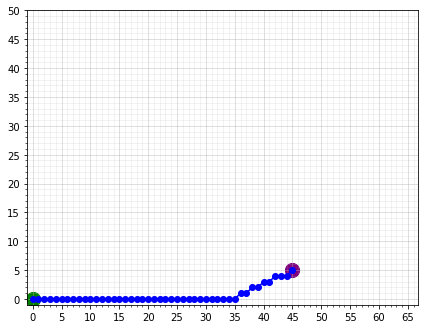

In [19]:
# Define the start and end goal
start = (0,0)
goal = (45,5)
max_val = 50

navigation.runAstar(start, goal, max_val, occupancy_grid, cmap)

In [13]:
def analyze():
    print("ANALYSING")
    cap = cv2.VideoCapture(2)
    ret, raw_frame = cap.read()
    frame = raw_frame.copy()
    
    # Find robot and destination positions
    robot_center_absolute = find_thymio_center(frame)
    robot_front_absolute = find_thymio_front(frame)
    destination_center_aboslute = find_destination_center(frame)
    
    # Detect obstacles positions
    # Read image with obstacles as black rectangles
    frame_objects = frame.copy()
    test = find_objects(frame_objects)
    
    test_dilated = cv2.dilate(test, cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 5)))
    ret,thresh = cv2.threshold(test,10,255,0) 

    # Combine all
    THYMIO_WIDTH = 92
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (THYMIO_WIDTH, THYMIO_WIDTH))
    dilated = cv2.dilate(test, kernel)
    compressed = cv2.resize(test, (0, 0), fx = 0.0694, fy = 0.0694) 
    #Creating the grid
    max_val = 50 # Size of the map
    fig, ax = create_empty_plot(67,50)
    # Creating the occupancy grid
    np.random.seed(0) # To guarantee the same outcome on all computers
    data = compressed * 20 # Create a grid of 67 x 50 with objects values
    cmap = colors.ListedColormap(['white', 'black']) # Select the colors with which to display obstacles and free cells
    # Converting the random values into occupied and free cells
    limit = 10 
    occupancy_grid = data.copy()
    #occupancy_grid_flipped = cv2.flip(occupancy_grid, flipCode = 0)
    occupancy_grid[data>limit] = 1
    occupancy_grid[data<=limit] = 0
    # Displaying the map
    ax.imshow(cv2.flip(occupancy_grid, 0), cmap=cmap)
    plt.title("Map : free cells in white, occupied cells in black");

    # Define the start and end goal
    start = (int(robot_center_absolute[0]*0.0694), int(robot_center_absolute[1]*0.0694))#(int(robot_center_absolute[0]*0.0694),int(50-robot_center_absolute[1]*0.0694))
    goal = (int(destination_center_absolute[0]*0.0694), int(destination_center_absolute[1]*0.0694))
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE - 
    # EXECUTION AND PLOTTING OF THE ALGORITHM
    # -----------------------------------------
    # List of all coordinates in the grid
    x,y = np.mgrid[0:max_val:1, 0:max_val:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
    coords = list([(int(x[0]), int(x[1])) for x in pos])
    # Define the heuristic, here = distance to goal ignoring obstacles
    h = np.linalg.norm(pos - goal, axis=-1)
    h = dict(zip(coords, h))
    # Run the A* algorithm
    path, visitedNodes = A_Star(start, goal, h, coords, cv2.flip(occupancy_grid, 0).transpose(), movement_type="8N")
    path = np.array(path).reshape(-1, 2).transpose()
    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
    # Displaying the map
    fig_astar, ax_astar = create_empty_plot(67,50)
    ax_astar.imshow(cv2.flip(occupancy_grid, 0), cmap=cmap)
    # Plot the best path found and the list of visited nodes
    ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
    ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
    return robot_front_absolute, robot_center_absolute, destination_center_absolute, path


In [15]:
def dist(current_x, current_y, goal_x, goal_y):
    return np.sqrt((goal_x-current_x)**2-(goal_y-current_y)**2), 


# MOVE THYMIO

In [7]:
th = Thymio.serial(port="COM9", refreshing_rate=0.1)

### Calculate Thymio angle

In [16]:
np.sqrt(2)

1.4142135623730951

In [8]:
print(robot_center_absolute)
print(robot_front_absolute)

NameError: name 'robot_center_absolute' is not defined

In [27]:
robot_center_absolute[0]

NameError: name 'robot_center_absolute' is not defined

In [9]:
def angleCalculator(robot_front_absolute, robot_center_absolute, destination_center_absolute):
    angleRobotAbsolute = np.arctan2(robot_front_absolute[1] - robot_center_absolute[1], robot_front_absolute[0] - robot_center_absolute[0])
    #print("Robot : ", np.rad2deg(angleRobotAbsolute))
    angleGoalAbsolute = np.arctan2(destination_center_absolute[1] - robot_center_absolute[1], destination_center_absolute[0] - robot_center_absolute[0])
    #print("Angle goal absolute:", np.rad2deg(angleGoalAbsolute))
    return np.rad2deg(angleGoalAbsolute - angleRobotAbsolute)%360
def distanceCalculator(current_x, current_y, goal_x, goal_y):
    return np.sqrt((goal_x-current_x)**2-(goal_y-current_y)**2), 

In [ ]:
MOVING = True
pointID = 0
angleReached = False
distanceReached = False
th.set_var("motor.left.target", 0)
th.set_var("motor.right.target", 0)
robot_front_absolute, robot_center_absolute, destination_center_absolute, path = analyze()
#print(robot_center_absolute)
while(MOVING):
    angleToRotate = angleCalculator(robot_front_absolute, robot_center_absolute, [path[0][pointID],path[1][pointID]])
    print(angleToRotate)
    if (abs(angleToRotate)<5):
        th.set_var("motor.left.target", 0)
        th.set_var("motor.right.target", 0)
        angleReached = True
    if not(angleReached):
        th.set_var("motor.left.target", 30)
        th.set_var("motor.right.target", 2**16 -30)
    else:
        distanceToGoal = distanceCalculator(robot_center_absolute[0],robot_center_absolute[1],robot_center_absolute, path[0][pointID], path[1][pointID])
        if (abs(distanceToGoal)<3):
            th.set_var("motor.left.target", 0)
            th.set_var("motor.right.target", 0)
            distanceReached = True
            pointID = pointID + 1
            if (pointID > len(path[0])):
                MOVING = False
        if not (distanceReached):
            th.set_var("motor.left.target", 30)
            th.set_var("motor.right.target", 2**16 - 30)
    robot_front_absolute, robot_center_absolute, destination_center_absolute, _ = analyze()
    #print(robot_front_absolute)

In [477]:
th.set_var("motor.left.target", 0)
th.set_var("motor.right.target", 0)

th.set_var("motor.left.target", 2**16-200)
th.set_var("motor.right.target", 2**16-200)

time.sleep()

th.set_var("motor.left.target", 0)
th.set_var("motor.right.target", 0)

In [157]:
th.set_var('motor.left.target', 0)